# Visualize the dataset

In [1]:
import os
import warnings

import torch
import cv2
import numpy as np
from e2edet.utils import visualization as vis
from e2edet.dataset.helper import CocoDetection
from e2edet.dataset.coco import convert_coco_poly_to_mask
from pycocotools.coco import COCO

In [ ]:
if os.environ.get("E2E_DATASETS") is None:
    warnings.warn("E2E_DATASETS environment should be imported!")

In [2]:
catergories_path = os.path.join(os.environ["E2E_DATASETS"], "coco/vocabs/coco_categories.txt")
categories = []
with open(catergories_path) as f:
    categories = f.read().split("\n")

In [3]:
annFile = os.path.join(os.environ["E2E_DATASETS"], "coco/annotation/instances_val2017.json")
image_path = os.path.join(os.environ["E2E_DATASETS"], "coco/image/val2017/{:012d}.jpg")
val_coco = COCO(annFile)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [4]:
valset = CocoDetection(os.path.join(os.environ["E2E_DATASETS"], "coco/image/val2017"), annFile)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [5]:
def load_and_visualize_gt(image, target, show_mask=False):
    img_w, img_h = image.size
    
    gts = []
    for item in target:
        x, y, w, h = item["bbox"]
        
        processed_item = {"bbox": [x, y, x+w, y+h], "category_id": item["category_id"]}
        if show_mask:
            processed_item["mask"] = convert_coco_poly_to_mask([item["segmentation"]], img_h, img_w)[0]
        gts.append(processed_item)
        
    img = np.array(image)[:,:,::-1].copy()
    for i, gt in enumerate(gts):
        color = vis.get_color(i)
        
        bbox2d = torch.tensor(gt["bbox"])
        position = np.array(gt["bbox"][:2])
        label = categories[gt["category_id"]]
        vis.draw_bbox2d(img, bbox2d, color=color, thickness=2)
        vis.draw_text(img, label, position, color=(0,0,0))
        if show_mask:
            vis.apply_mask(img, gt["mask"], color, alpha=0.5)
        
    print(img.shape)
    vis.imshow(img)

(426, 640, 3)


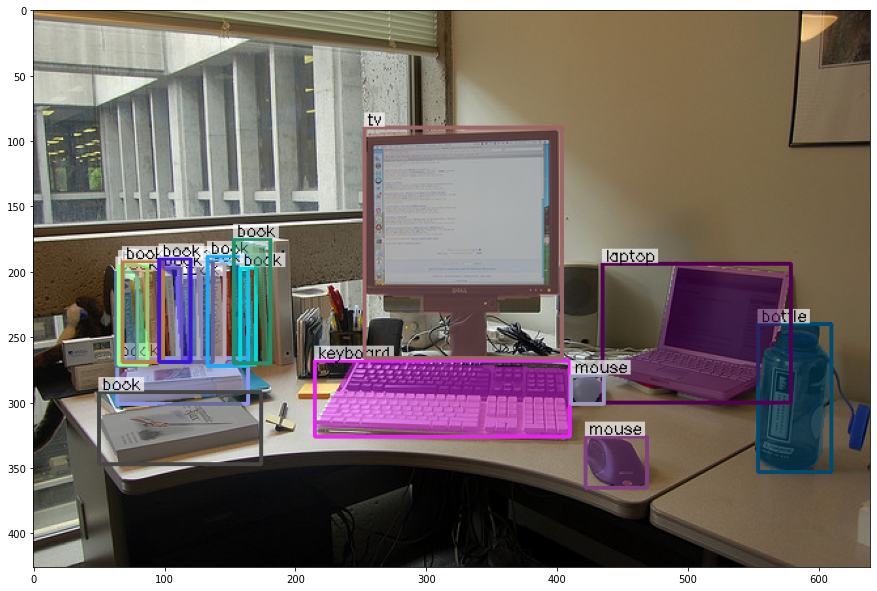

In [6]:
image, target = valset[255]
load_and_visualize_gt(image, target, show_mask=True)

# Test Visualization

In [7]:
from e2edet.utils.configuration import load_yaml
from e2edet.utils.general import get_root
from e2edet.dataset.processor import build_processor
from e2edet.dataset.coco import ConvertCocoPolysToMask

In [8]:
def load_and_visualize(image, target, show_mask=False):    
    gts = []
    for i in range(target["boxes"].shape[0]):
        x1, y1, x2, y2 = target["boxes"][i].tolist()
        
        processed_item = {"bbox": [x1, y1, x2, y2], "category_id": target["labels"][i]}
        if show_mask:
            processed_item["mask"] = target["masks"][i]
        gts.append(processed_item)
        
    img = np.array(image)[:,:,::-1].copy()
    for i, gt in enumerate(gts):
        color = vis.get_color(i)
        
        bbox2d = torch.tensor(gt["bbox"])
        position = np.array(gt["bbox"][:2])
        label = categories[gt["category_id"]]
        vis.draw_bbox2d(img, bbox2d, color=color, thickness=2)
        vis.draw_text(img, label, position, color=(0,0,0))
        if show_mask:
            vis.apply_mask(img, gt["mask"], color, alpha=0.5)
        
    print(img.shape)
    vis.imshow(img)

In [9]:
log_dir = os.path.join(get_root(), "config/COCO-InstanceSegmentation")
config_path = os.path.join(log_dir, "boxer2d_R_101_5x_lsj.yaml")

config = load_yaml(config_path)
image_processor_config = config.dataset_config.detection.processors.image_train_processor
image_processor = build_processor(image_processor_config)
prepare = ConvertCocoPolysToMask(config.dataset_config.detection["use_mask"])

include path: /media/deepstorage01/home2/duykien/3D-ObjectDect/e2edet/config/base_boxer2d_detection.yaml


In [10]:
idx = 265
image, target = valset[idx]

(334, 500, 3)


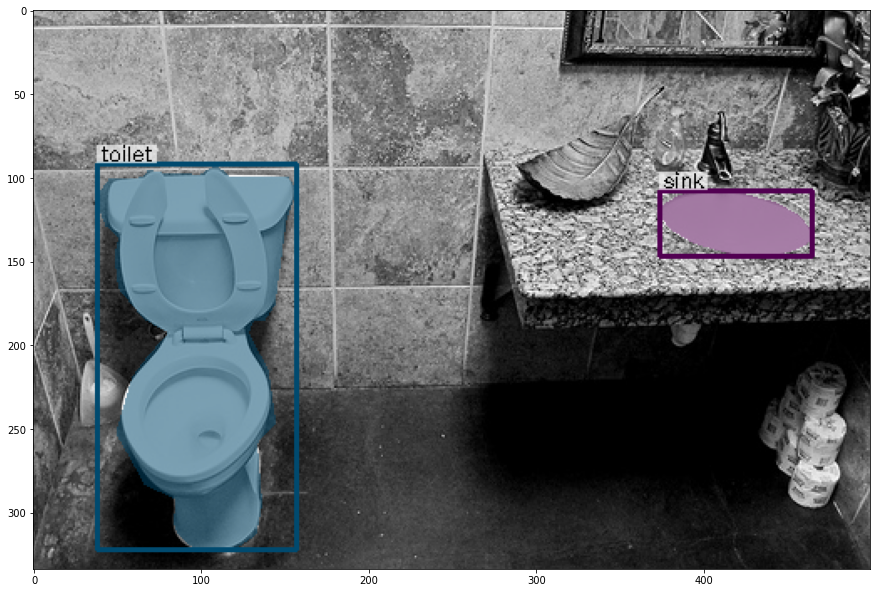

In [11]:
load_and_visualize_gt(image, target, show_mask=True)

## Visualize demo

In [13]:
from detectron2.utils.visualizer import Visualizer

from e2edet.utils.configuration import load_yaml
from e2edet.utils.general import get_root
from e2edet.dataset.processor import build_processor
from e2edet.dataset import build_dataset
from e2edet.model import build_model
from e2edet.dataset.coco import ConvertCocoPolysToMask

In [16]:
log_dir = os.path.join(get_root(), "..", "save/COCO-InstanceSegmentation")
model_path = "boxer2d_R_101_3x_no_mask_proposal/boxer2d_final.pth"
config_path = "boxer2d_R_101_3x_no_mask_proposal/config.yaml"
vis_path = "boxer2d_R_101_3x_no_mask_proposal/vis"

In [30]:
class BoxeRDemo:
    def __init__(self, root_path, model_path, config_path, current_device=torch.device("cpu")):
        model_path = os.path.join(root_path, model_path)
        config_path = os.path.join(root_path, config_path)
        self.current_device = current_device
        print("Loading model from", model_path)
        
        self.config = load_yaml(config_path)
        self._init_processors()
        self.model = self._build_boxer(model_path)

    def _init_processors(self):
        task = self.config.task
        task_config = getattr(self.config.dataset_config, task)
        image_processor_config = task_config.processors.image_test_processor
        answer_processor_config = task_config.processors.answer_processor
        
        self.dataset = build_dataset(self.config, "test", self.current_device)
        self.image_processor = self.dataset.image_test_processor
        self.answer_processor = self.dataset.answer_processor
        self.prepare = ConvertCocoPolysToMask(task_config["use_mask"])

    def _build_boxer(self, model_path):
        num_classes = self.dataset.get_answer_size()
        model = build_model(self.config, num_classes)
        
        ext = model_path.split(".")[-1]
        state_dict = torch.load(model_path, map_location="cpu")
        if ext == "ckpt":
            state_dict = state_dict["model"]
            
        if list(state_dict.keys())[0].startswith('module') and not hasattr(model, 'module'):
            state_dict = self._multi_gpu_state_to_single(state_dict)
        
        print("Loading model:", model.load_state_dict(state_dict))
        model.to(self.current_device)
        model.inference()
        
        return model

    def _multi_gpu_state_to_single(self, state_dict):
        new_sd = {}
        for k, v in state_dict.items():
            if not k.startswith('module.'):
                raise TypeError("Not a multiple GPU state of dict")
            k1 = k[7:]
            new_sd[k1] = v
        return new_sd

    @torch.no_grad()
    def predict(self, image, image_id=0, threshold=0.5):
        visualizer = Visualizer(np.asarray(image)[:,:,::-1])
        
        target = {"image_id": image_id, "annotations": []}
        image, target = self.prepare(image, target)
        sample = {"image": image}
        
        sample, target = self.image_processor(sample, target)
        
        h, w = sample["image"].shape[-2:]
        sample["image"] = sample["image"][None]
        sample["mask"] = sample["image"].new_zeros(1, h, w).bool()
        target = [target]
        
        sample = {
            k: v.to(self.current_device) for k, v in sample.items()
        }
        target = [
            {k: v.to(self.current_device) for k, v in t.items()}
            for t in target
        ]
        
        output = self.model(sample, target)
        results = self.dataset.format_for_evalai(output, target, threshold=threshold, return_rles=True)
        
        if len(results[image_id]["boxes"]) > 0:
            boxes = results[image_id]["boxes"].detach().cpu().numpy()
            labels = [self.answer_processor.idx2cls(label) for label in results[image_id]["labels"].tolist()]
            masks = results[image_id]["rles"]

            visualizer.overlay_instances(boxes=boxes, labels=labels, masks=masks)
        
        return visualizer.get_output().get_image()

In [31]:
demo = BoxeRDemo(log_dir, model_path, config_path, torch.device("cuda"))

Loading model from /media/deepstorage01/home2/duykien/3D-ObjectDect/e2edet/../save/COCO-InstanceSegmentation/boxer2d_R_101_3x_no_mask_proposal/boxer2d_final.pth
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loaded pretrained resnet: <All keys matched successfully>
Loading model: <All keys matched successfully>


In [34]:
import requests
from PIL import Image

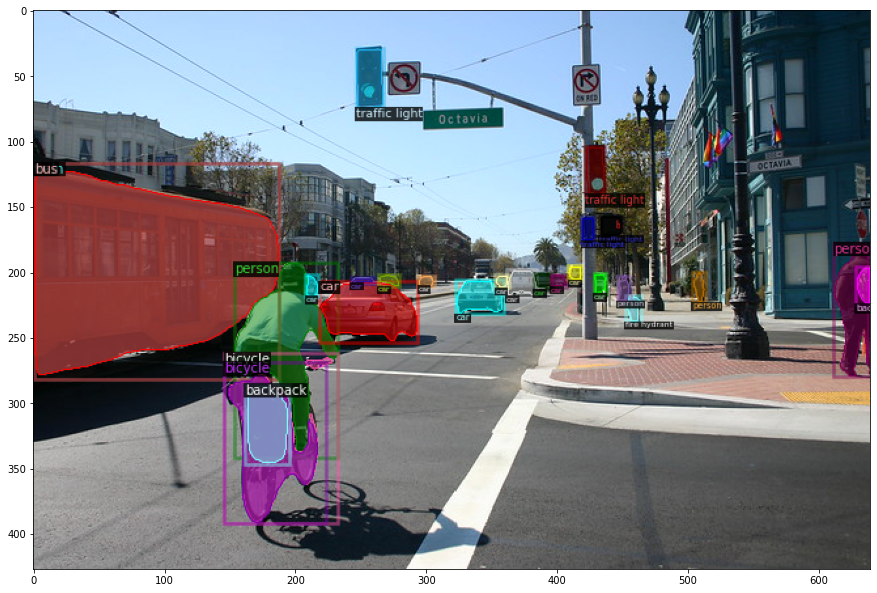

In [35]:
url = "https://farm1.staticflickr.com/164/391500639_fb1c5de6df_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_vis = demo.predict(image, threshold=0.3)
vis.imshow(image_vis)

# Visualization test-dev set

In [36]:
annFile = os.path.join(os.environ["E2E_DATASETS"], "coco/annotation/image_info_test-dev2017.json")
image_path = os.path.join(os.environ["E2E_DATASETS"], "coco/image/test2017/{:012d}.jpg")
test_coco = COCO(annFile)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [37]:
testset = CocoDetection(os.path.join(os.environ["E2E_DATASETS"], "coco/image/test2017"), annFile)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


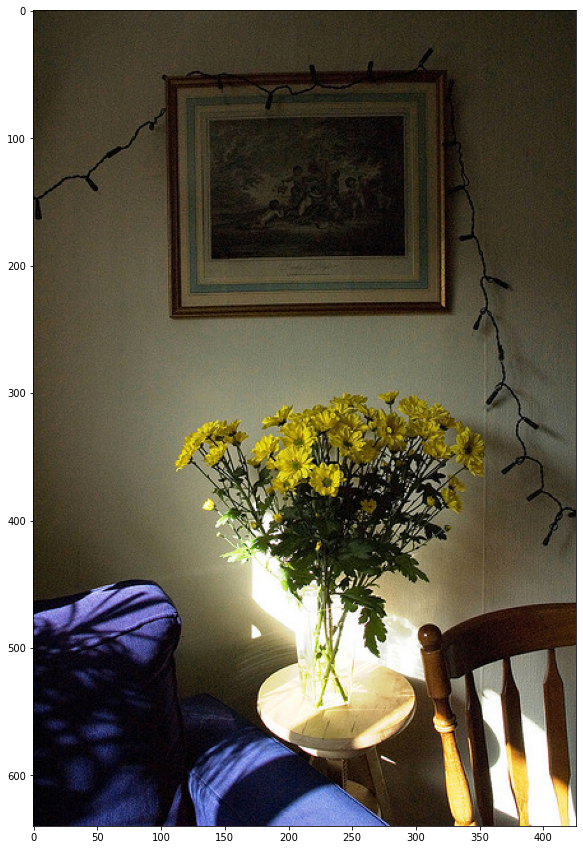

In [38]:
idx = 247
image, target = testset[idx]
img_id = testset.ids[idx]

img = cv2.imread(image_path.format(img_id))
vis.imshow(img)

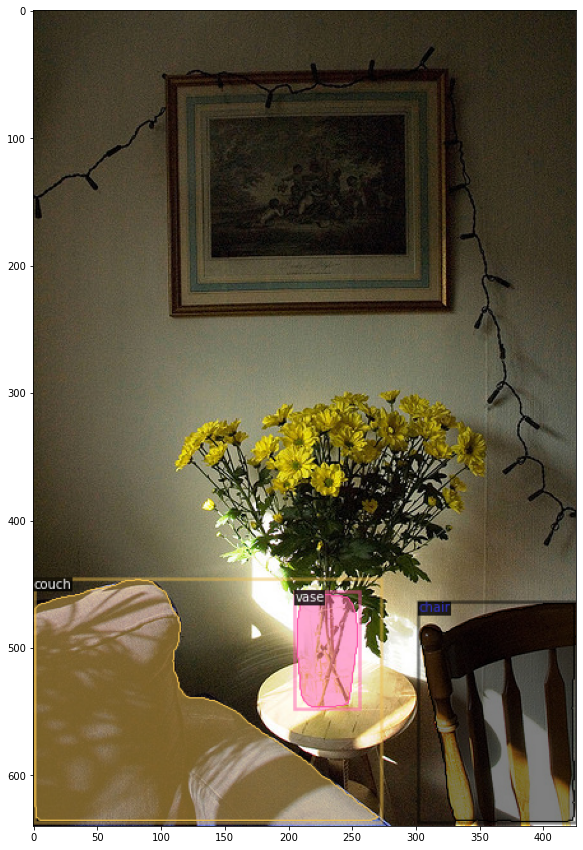

In [39]:
image_vis = demo.predict(image, img_id, 0.3)
vis.imshow(image_vis)

In [ ]:
if not os.path.isabs(vis_path):
    vis_path = os.path.join(log_dir, vis_path)

if not os.path.exists(vis_path):
    os.makedirs(vis_path, exist_ok=True)
    
for i in range(1000):
    if i % 50 == 0 and i > 0:
        print(f"{i}/1000")
    image, target = testset[i]
    img_id = testset.ids[i]
    image_vis = demo.predict(image, img_id, threshold=0.3)
    vis.imsave(os.path.join(vis_path, "test_{}.png".format(i)), image_vis)